# Modified discrete cosine transform (MDCT)

## Introduction

In processing speech and audio, we often need to split the signal into
segments or [windows](../Representations/Windowing.ipynb), because

-   audio signals are relatively slowly changing over time, such that by
    segmenting the signal in short windows allows assuming that the
    signal is stationary, which is a pre-requisite of many efficient
    methods such as [spectral analysis](../Representations/Spectrogram_and_the_STFT.ipynb),
-   transform-domain analysis, such as spectral analysis, requires that
    we transform the entire signal in one operation, which in turn
    requires that we have received the entire signal, before we can
    start processing. In for example telecommunications, this would mean
    that we have to wait for a sentence to finish before we can begin
    sending, and thus reconstruction the sentence at the receiver would
    have to wait until the whole sentence has finished, incurring a
    significant delay in communication.

In practical scenarios, we thus always apply windowing before
processing.

Applying spectral processing, such as processing in the
[STFT](../Representations/Spectrogram_and_the_STFT.ipynb) domain, in *telecommunications
applications* however has a significant drawback. We need windows which
are *overlapping* to allow *perfect reconstruction*, that is, we require
that we can perfectly reconstruct the original signal from the windowed
signal. Overlaps however mean that consecutive windows share information
from the same samples (see Figure on the right). The same information
thus has to be encoded in *both windows*, which is inefficient. With
coding a signal, our target is to compress the information to the fewest
possible bits, but if we encode a part of the information twice, we
increase the amount of information we need to encode. The STFT domain
thus causes *over-coding*, where in effect, two different bit-streams
could represent the same output signal.

The *modified discrete cosine transform* (MDCT) is a solution to the
over-coding problem, which uses projection-operators at the overlaps
such that the information in consecutive windows are orthogonal to each
other. Since information is therefore perfectly retained, the amount of
information is not increased nor decreased, and we say that this
operator is *critically sampled*.

The MDCT thus provides a time-frequency representation of the input
signal, where we can analyse and process the time-evolution of
frequency-components. It shares most of the beneficial properties of the
STFT, wherein a signal processed in the MDCT-domain, remains continuous
in the time-domain and we can use FFT-based operations for efficient
implementations. Perhaps the most significant difference between the
STFT and MDCT, other than perfect sampling of the MDCT, is that where
the STFT is a complex-valued representation, the MDCT is a real-valued
representation when the input is real-valued.

Due to these beneficial properties of the MDCT, it is the most commonly
used time-frequency transform in speech and audio coding and employed in
standardized codecs such as MPEG USAC, 3GPP EVS and Bluetooth LC3.

![ola2-1.png](attachments/148295002.png)


## Executive summary of algorithm

The MDCT is based on taking the symmetric and anti-symmetric parts of
the signal at the overlap, such that the symmetric part goes to the one
window and the antisymmetric to the other. We furthermore window those
symmetric and antisymmetric parts such that they converge smoothly to
zero at the borders. Consecutive windows are thus orthogonal at the
overlap such that information is split exactly in half and we obtain
perfect reconstruction and critical sampling. Moreover, since the
segments are windowed, we do not have any difficulties with
discontinuities.

Secondly, we take the discrete cosine transform (DCT) of the windowed
signal (=of the orthogonal projection). The conventional DCT has to,
however, be adjusted such that its phase and symmetries match with the
symmetric and anti-symmetric parts. Hence the name *modified DCT or
MDCT*. The matching of symmetries is possible only through this
modification of the DCT and cannot be generalized to the discrete
Fourier transform (DFT).

The (anti)symmetric part of signal then "looks like the signal" which
would have this symmetry. In other words, we introduce a *deviation*
from the original signal and this deviation is known as a *time-domain
aliasing* component, since it is similar to the aliasing effects which
occur with the DFT. However, in reconstruction, we add the symmetric and
anti-symmetric parts together, such that they cancel each other, which
is known as *time-domain aliasing cancellation (TDAC)*. The TDAC is
equivalent with the orthogonal projection laying at the basis of the
MDCT, and thus a central property of the MDCT. 

## Visual Explanation

We start with a sound sample and extract a segment from it.

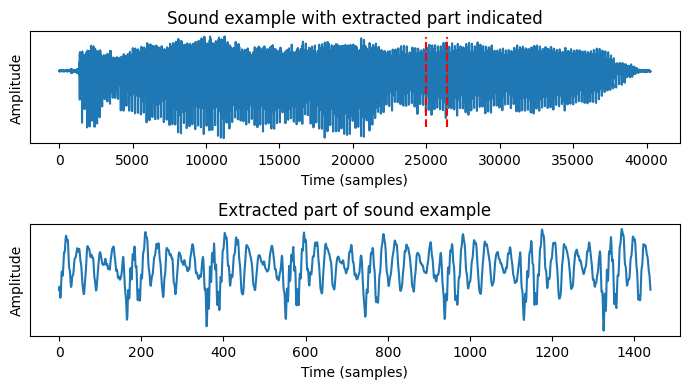

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import IPython.display as ipd 

sample_rate, data = scipy.io.wavfile.read('sounds/soundexample.wav')

window_length_ms = 30
window_length = (sample_rate*window_length_ms)//1000
window_step = window_length//2
window_count = 5

ix = np.arange(25000,25000+window_step*(window_count+1))

plt.figure(figsize=(7,4))

plt.subplot(211)
plt.title('Sound example with extracted part indicated')
plt.plot(data)
plt.plot([ix[0],ix[0]],[-10000,6000],'r--')
plt.plot([ix[-1],ix[-1]],[-10000,6000],'r--')
plt.ylabel('Amplitude')
plt.xlabel('Time (samples)')
plt.yticks([])

plt.subplot(212)
plt.title('Extracted part of sound example')
plt.plot(data[ix])
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.yticks([])

plt.tight_layout()
plt.show()

ipd.display(ipd.Audio(data,rate=sample_rate))

data = data[ix]

We can window this segment it with rectangular windows (i.e. no windowing function).
The overlapping areas between windows are the regions between black dashed lines.

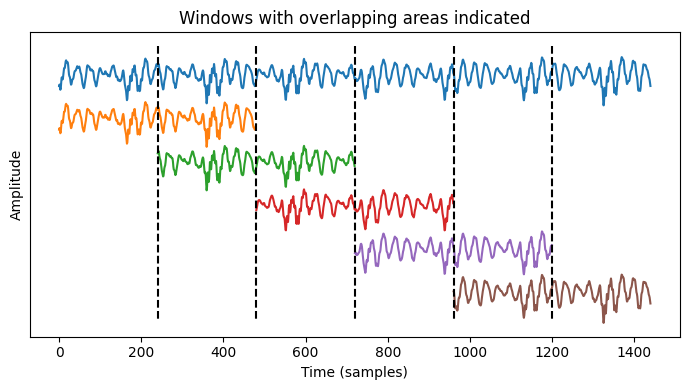

In [50]:
plt.figure(figsize=(7,4))
plt.plot(data)
for win_idx in np.arange(window_count,dtype=np.int32):
    start_idx = window_step*win_idx
    end_idx = start_idx + window_length
    idx = np.arange(start_idx,end_idx,dtype = np.int32)
    plt.plot(idx, data[idx]-12000*(win_idx+1))

for win_idx in np.arange(1,window_count+1):
    plt.plot(win_idx*window_step*np.array([1,1]),[8000, -12000*(window_count+.6)],'k--')

plt.ylabel('Amplitude')
plt.xlabel('Time (samples)')
plt.title('Windows with overlapping areas indicated')
plt.yticks([])
plt.tight_layout()

By definition, the same signal appears in every pair of subsequent windows. In transmission applications this is a problem, because the same information would then have to be transmitted twice.

Such overcoding can be avoided by splitting the signal into two orthogonal parts in the overlaps. We can do this by splitting the signal into its symmetric and antisymmetric parts. The sum of the two parts then still adds up to the original signal.

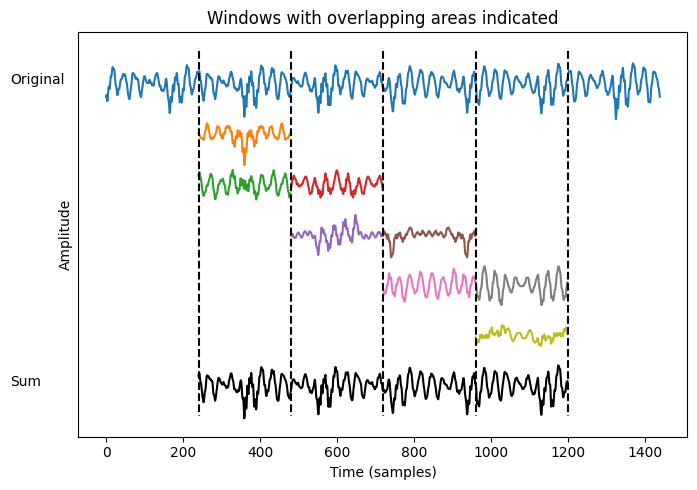

In [74]:
plt.figure(figsize=(7,5))
plt.plot(data)

def Psplit(x):
    return .5*(x+np.flipud(x)), .5*(x-np.flipud(x))

for win_idx in np.arange(1,window_count):
    start_idx = window_step*win_idx
    end_idx = start_idx + window_step
    idx = np.arange(start_idx,end_idx,dtype = np.int32)
    s,a = Psplit(data[idx])
    plt.plot(idx, s-12000*(win_idx))
    plt.plot(idx, a-12000*(win_idx+1))
    plt.plot(idx, a+s -12000*(window_count+1),'k')

for win_idx in np.arange(1,window_count+1):
    plt.plot(win_idx*window_step*np.array([1,1]),[8000, -12000*(window_count+1.6)],'k--')

plt.ylabel('Amplitude')
plt.xlabel('Time (samples)')
plt.title('Windows with overlapping areas indicated')
plt.yticks([])

plt.text(-250,0,'Original')
plt.text(-250,-12000*(window_count+1),'Sum')
plt.tight_layout()

This split does not use any windowing function and thus we see that there are sometimes big discontinuities at the center of the window. Similar discontinuities will happen also at window edges, if the windows are modified befor reconstruction.

Surprisingly, this split into parts can be directly combined with windowing, before and after processing. The perfect reconstruction of the signal still works.

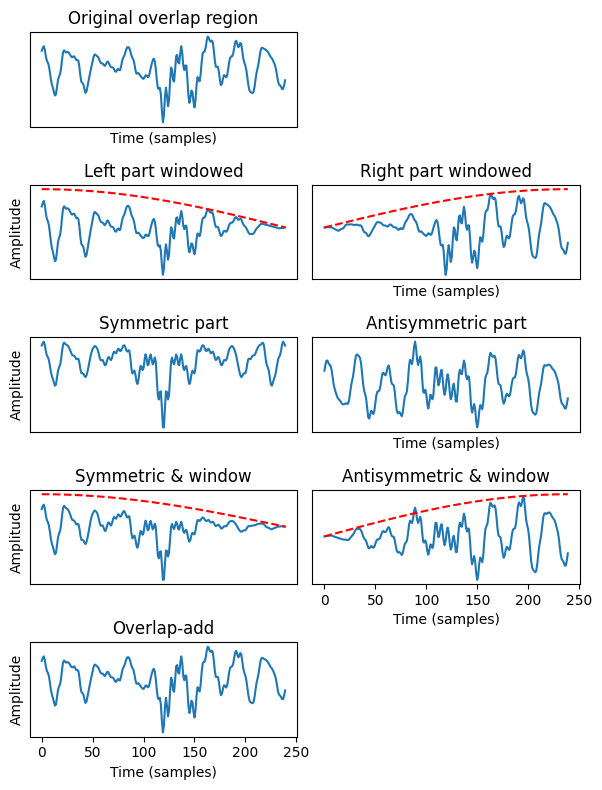

In [104]:
lwin = np.cos(np.pi*np.arange(.5,window_step)/(2*window_step))
rwin = np.flipud(lwin)

datawin = data[window_step:2*window_step]

plt.figure(figsize=(6,8))
plt.subplot(521)
plt.plot(datawin)
plt.xlabel('Time (samples)')
plt.title('Original overlap region')
plt.yticks([])
plt.xticks([])

plt.subplot(523)
plt.plot(datawin*lwin)
plt.plot(lwin*np.max(datawin),'r--')
plt.ylabel('Amplitude')
plt.title('Left part windowed')
plt.yticks([])
plt.xticks([])

plt.subplot(524)
plt.plot(datawin*rwin)
plt.plot(rwin*np.max(datawin),'r--')
plt.xlabel('Time (samples)')
plt.title('Right part windowed')
plt.yticks([])
plt.xticks([])

plt.subplot(525)
plt.plot(datawin*lwin + np.flipud(datawin*lwin))
plt.ylabel('Amplitude')
plt.title('Symmetric part')
plt.yticks([])
plt.xticks([])

plt.subplot(526)
plt.plot(datawin*rwin - np.flipud(datawin*rwin))
plt.xlabel('Time (samples)')
plt.title('Antisymmetric part')
plt.yticks([])
plt.xticks([])

plt.subplot(527)
plt.plot(lwin*(datawin*lwin + np.flipud(datawin*lwin)))
plt.plot(lwin*np.max(datawin),'r--')
plt.ylabel('Amplitude')
plt.title('Symmetric & window')
plt.yticks([])
plt.xticks([])

plt.subplot(528)
plt.plot(rwin*(datawin*rwin - np.flipud(datawin*rwin)))
plt.plot(rwin*np.max(datawin),'r--')
plt.xlabel('Time (samples)')
plt.title('Antisymmetric & window')
plt.yticks([])

plt.subplot(529)
plt.plot(lwin*(datawin*lwin + np.flipud(datawin*lwin)) + rwin*(datawin*rwin - np.flipud(datawin*rwin)))
plt.ylabel('Amplitude')
plt.xlabel('Time (samples)')
plt.title('Overlap-add')
plt.yticks([])

plt.tight_layout()
plt.show()

When applying the same process for all windows, we can reconstruct the whole signal.

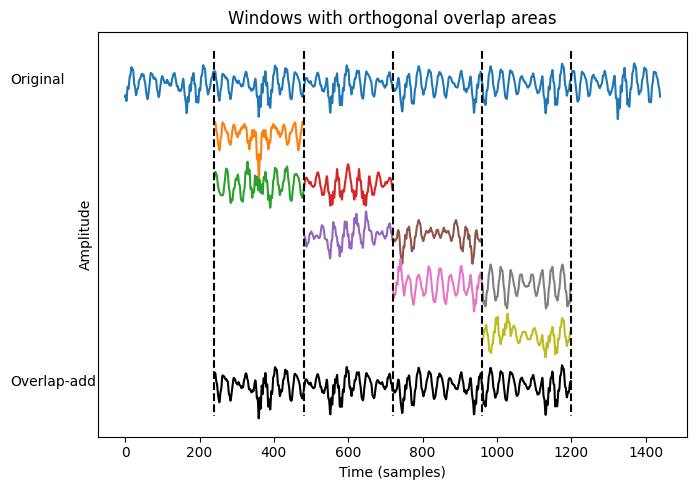

In [107]:
hwin = np.cos(np.pi*np.arange(.5,window_step)/(2*window_step))

plt.figure(figsize=(7,5))
plt.plot(data)

def winsplit(x,hwin):
    fwin = np.flipud(hwin)
    l = hwin*x
    r = fwin*x
    return (l+np.flipud(l)), (r-np.flipud(r))

def winmerge(s,a,hwin):
    fwin = np.flipud(hwin)
    return s*hwin + a*fwin

for win_idx in np.arange(1,window_count):
    start_idx = window_step*win_idx
    end_idx = start_idx + window_step
    idx = np.arange(start_idx,end_idx,dtype = np.int32)
    s,a = winsplit(data[idx],hwin)
    plt.plot(idx, s-12000*(win_idx))
    plt.plot(idx, a-12000*(win_idx+1))
    plt.plot(idx, winmerge(s,a,hwin) -12000*(window_count+1),'k')

for win_idx in np.arange(1,window_count+1):
    plt.plot(win_idx*window_step*np.array([1,1]),[8000, -12000*(window_count+1.6)],'k--')

plt.ylabel('Amplitude')
plt.xlabel('Time (samples)')
plt.title('Windows with orthogonal overlap areas')
plt.yticks([])

plt.text(-310,0,'Original')
plt.text(-310,-12000*(window_count+1),'Overlap-add')
plt.tight_layout()

This representation is compatible with the discrete cosine transform (DCT), such that we can take the DCT of each window with orthogonal overlaps. We then obtain a time-frequency representation of the signal, where each frame is independent of all other frames.

## Mathematical Definition

Suppose $x$ is a $N\times1$ vector representing the overlapping region shared
by two consecutive windows, such as the are between 15 and 30 ms in the
figure above and right. Our task is to design a projection matrix $P$ of
size $N\times N$, such that we can split $x$ into two orthogonal parts as

$$ \begin{cases} x_L &= Px\\ x_R &= P_0x \end{cases} $$

where the $P_{0}$ is the kernel of $P$ and thus $ P_0 P^T = 0,
$ such that we can reconstruct $x$ as

$$ P^T x_L+P_0^Tx_R = P^T P x + P_0^T P_0 x = (P^T P + P_0^T P_0)x =
x, $$

since $ P^T P + P_0^T P_0 = I $ by definition.

The vectors $x_{L}$ and $x_{R},$ corresponding to the
left and right windows, are thus both of length N/2 and contain each
exactly half the information of $x$.

Though this is a mathematically clean solution, it is not practical,
since after processing the reconstructed signal could have
discontinuities. For example, suppose that we define $P$ as the operator
which extracts the symmetric part of $x$, that is, $ P = [I,
J]\sqrt{1/2}, $ where $I$ is the $(N/2)\times(N/2)$ identity matrix and
$J$ its left-right flipped counterpart (reverse diagonal). The kernel is
then $ P_0 = [I, -J]\sqrt{1/2}. $ If we make a small modification
to the signal as $ x_L':=x_L+d, $ then the reconstruction is $
x':=P^Tx_L+P^Td+P_0^Tx_R=x+P^Td, $ which means that original signal is
changed by $P^Td$. Unfortunately, however, this component does
not go to zero at the border such that processed signal is not
continuous. Specifically, for example, consider a vector $ d =
[1,\,1,\,\dotsc,\,1]^T, $ which gives $ P^Td =
\sqrt{1/2}[1,\,1,\,\dotsc,\,1]^T, $ which is clearly non-zero
at both ends of the vector.

The reason for this problem is that the definition did not include a
windowing function. Recall that windowing is sample-by-sample
multiplication of the signal with a windowing function. In matrix
notation, we can implement this by multiplying the input signal $x$ with
a diagonal matrix $W$, where the diagonal elements correspond to the
windowing function. The windowed signal is then $Wx$. The symmetric
projection $P$ can then be applied on the windowed signal such that the
windowed left and right signals are

$$ 
\begin{cases} x_L &= PWx := P'x\\ x_R &= P_0'x = P_0JWJx
\end{cases} 
$$

where the $P_{0}'$ is the kernel of $P'$, and $JWJ$ is simply
the backwards part of the window (if $W$ is the increasing left part of
the window, then $JWJ$ is the decreasing right part of the window). Note
that the relationship between the two kernels, $ P_0'=P_0JWJ $
applies only to the symmetric operator defined above, but generally not.
In any case, the above definition now includes windowing and the
orthonormal projection such that the beneficial properties of perfect
reconstruction and critical sampling are retained, but now the signal is
also going smoothly to zero at the edges, because we applied a windowing
function.

Above we have thus developed a windowing operation which has the
properties we need. However, our goal was to obtain a time-frequency
transform of the signal, so we are still missing the time-frequency
transform.


Our objective is to find a spectral representation of the windowed input
signal. Importantly, note that above we studied the properties at the
overlap, where we took an orthonormal projection of the overlap to
obtain the left-part of the current window $x_{L}$ and
right-part of the preceeding window $x_{R}$. To avoid confusion,
we here have to include the frame indices, such that the overlapping
parts are now, respectively, $x_{L,k}$ and $x_{R,k-1}$.
The spectral representation, however, should come from a single frame,
that is, we define frame $k$ as

$$ \widehat x_k := \begin{bmatrix}x_{L,k} \ x_{R,k}
\end{bmatrix}. $$

To obtain the spectrum of $ \widehat x_k $ we can then multiply it
with a time-frequency transform matrix $D$, such that the frequency
representation is  $ y_k=D\widehat x_k $ and the reconstruction
is  $ \widehat x_k = D^T y_k, $ assuming that $D$
is orthogonal (as time-frequency transforms usually are).

In principle, the transform matrix $D$ could be any time-frequency
transform (DFT, DCT-I, DCT-II, DST-I etc.), but we need to choose one
specific. To evaluate the sanity of a particular choice, we should check
how well the transform works together with the prior orthogonal
projections. In particular, let us substitute the defitions of the left
and right parts into the above equation to obtain

$$ 
\widehat x_k := \begin{bmatrix}x_{L,k} \\ x_{R,k}
\end{bmatrix} = \begin{bmatrix}PWx_k \\ P_0JWJx_{k+1}
\end{bmatrix} = \begin{bmatrix}PW & P_0JWJ \end{bmatrix}
\begin{bmatrix}x_k \\ x_{k+1} \end{bmatrix} := \hat P
\begin{bmatrix}x_k \\ x_{k+1} \end{bmatrix}. 
$$

The combined windowing+projection+spectral transform is thus   
$y_k=D\hat P \begin{bmatrix}x_k \\ x_{k+1} \end{bmatrix} = M \begin{bmatrix}x_k \\ x_{k+1} \end{bmatrix}. $ 
To evaluate the
sanity of a particular time-frequency transform, we thus have to study
the basis functions of matrix $M$. By exhaustively going through
different options, it is simple to see that the implicit even/odd
extensions of DCTs align with the symmetric/antisymmetric projections
only for DCT-III. For the other options, we always get discontinuities
in the basis functions.

Heuristically speaking, we want the basis functions to "look like"
plausible signals, which could appear in a naturally appearing physical
system. More formally, such "nice looking" basis functions have less
leakage between spectral bins, and thus offer a more accurate
description of the spectral characteristics of the input signal.
{cite}`backstrom2017speech`


See also <https://github.com/audiolabs/lapped-transforms>


## References
```{bibliography}
:filter: docname in docnames
```